# Pairs Trading Strategy - Indian FX Market

This notebook devises a pairs trading strategy in the Indian FX Market. It dives deep into topics like cointegration and tests such as Engle-Granger Test and Hurst Exponent. I hope it serves as a useful introduction to pairs trading and statistical arbitrage.

## Introduction

Pairs Trading is an example of a market-neutral trading strategy. It was pioneered by researchers at Morgan Stanley in the early 1980s and is profitable in almost any market condition.

The general idea is to find a pair of securities X and Y such that a linear combination (or spread) of their time series is of the form $X_t - \beta Y_t = \mu_t$ where $\mu_t$ has a constant mean $\mu$, variance $\sigma$ and $\beta > 0$. We call $\mu_t$ a stationary time series. Note that stationary time series do not have to be constant!

Now, if $\mu_t$ is greater than its mean $\mu$, then it may indicate that X is overbought or Y is oversold. Hence, we enter a short position on X and enter a long position on Y. To eliminate as much risk as possible, the number of contracts bought of X and Y must be of the ratio $1:\beta$. Similarly, if $\mu_t$ is smaller than its mean $\mu$, then it may indicate X is oversold or Y is overbought. Hence, we enter a long position on X and enter a short position on Y. Contract ratio $1:\beta$ is the same.

Here are some important points and assumptions made in the following strategy:
- Bid and Offer prices are assumed to be equal.
- Margin required for opening positions is ignored.
- Starting capital is 100 rupees.

In [20]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.graphics.api as smg
from matplotlib import pyplot as plt
import seaborn as sns
from hurst import compute_Hc

# Finding suitable currency pairs to trade
# Select from GBP/USD, GBP/EUR, GBP/AUD, GBP/INR, GBP/JPY

#First, download data

tickers = ['USDINR=X','EURINR=X','AUDINR=X','GBPINR=X','CADINR=X','JPYINR=X',
          'CHFINR=X','HKDINR=X','SGDINR=X']

data = pd.DataFrame(columns=tickers)
try:
    for ticker in tickers:
        data[ticker] = yf.download(ticker,start='2016-01-01',end='2023-07-01')['Adj Close']
except:
    print('Download Failed')


        

## Process for finding cointegrated pairs

Out of the currencies listed in the above code cell, there are a total of 36 possible pairs to be checked. Hence, one individual test isn't likely to be enough to filter out the non-cointegrated and weakly cointergated pairs. 

Hence, we need to use more than 1 test to find the most cointegrated pairs. The most appropriate tests are Pearson's Moment Correlation Coefficient (PMCC), Engle-Granger Test and Hurst Exponent. 

### Pearson's Moment Correlation Coefficient

Pearson's Moment Correlation Coefficient (PMCC) measures the correlation between two time series. The formula is:

$\displaystyle PMCC(X,Y) = \frac {\sum xy - \frac{\sum x \sum y}{n}}{\sqrt{\sum x^2 - \frac{(\sum x^2)^2}{n}} 
{\sqrt{\sum y^2 - \frac{(\sum y^2)^2}{n}}}}$

PMCC takes a value between -1 and 1. 
- If PMCC equals 1, X and Y are perfectly positively correlated.
- If PMCC is between 0 and 1, X and Y are positively correlated.
- If PMCC equals 0, X and Y aren't correlated at all
- If PMCC is between 0 and -1, X and Y are negatively correlated.
- If PMCC equals -1, X and Y are perfectly negatively correlated

For our purposes, we seek a PMCC that is close to 1. I have set a lower bound for PMCC to be 0.8. If PMCC exceeds 0.8, the pair is kept, otherwise, the pair is discarded.

### Engle-Granger Test

We say that a time series is integrated with order d (I(d)) if d differences need to be taken to obtain a stationary time series. 

E.g. The sequence $2,6,12,20,..$ has order 2 since taking the difference between adjacent terms once gives $4,6,8,..$ and taking the difference between adjacent terms again gives $2,2,2,..$; a stationary time series. 

Two time series are cointegrated if a linear combination of both of them is a time series with an order of integration less than d. In our case, we can assume that our time series have order 1 (based on Nobel-winning work by Robert F.Engle and Clive W.J Granger on price time series). Hence, we know that if two of our time series are cointegrated, they are stationary.

The Engle-Granger Test is a hypothesis test used to determine if two time series are cointegrated. We do this using the following method:
- Estimate $\beta$ by performing linear regression using Ordinary Least Squares (X is predictor, Y is response). $\beta$ is estimated by the slope. This gives us the spread explained above.
- Test for Stationarity using Augmented Dickey-Fuller (ADF) Test at 5% significance level (see below)

#### ADF Test

The Augmented Dickey-Fuller test assumes that the spread follows an auto-regressive (AR) model. AR model is as follows:

$\Delta \mu_t = \alpha + \beta t + \gamma \mu_{t-1} \sum_{i=1}^{i=p} \delta_{i} \Delta \mu_{t-i} + \epsilon_t$ 

This equation models the $t^{th}$ difference ($\Delta \mu_t$) in the time series based on $t, \mu_{t-1}$ and the previous p differences. p is referred to as the lag order. $\epsilon_t$ is an error term with mean 0.

The spread is said to have a unit root if $\gamma = 0$. This means that the time series isn't stationary since as 
t tends to infinity, $\Delta \mu_t$ tends to positive or negative infinity depending on value of $\beta$. This means that in the long term, $\mu_t$ never reverts back to a mean.

The ADF test aims to test whether the spread has a unit root. The null hypothesis is $\gamma = 0$ while altenrative hypothesis is $\gamma < 0$. In this strategy, the confidence interval is 0.95 with a test statistic of -2.86 at this level of confidence. If the test statistic is less than -2.86, the null hypothesis is rejected and we classify the spread as a stationary time series.

### Hurst Exponent

The Hurst Exponent measures the long-term memory of a time series. It is a value between 0 and 1 and has the following criterion:

- 0 < H < 0.5: The spread is mean-reverting and is hence, stationary.
- H = 0.5: The spread follows a random walk.
- H > 0.5: The spread is a trending time series. 

We wish for the Hurst Exponent to be less than 0.5 for our purposes. 

### Results

Applying these techniques with each possible pair, filtering out the 'bad' pairs after each test gives 3 co-integrated pairs given below. As we can see, the spreads seem to revert back to 0 validating the method proposed above.




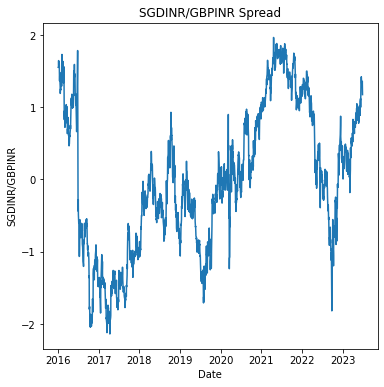

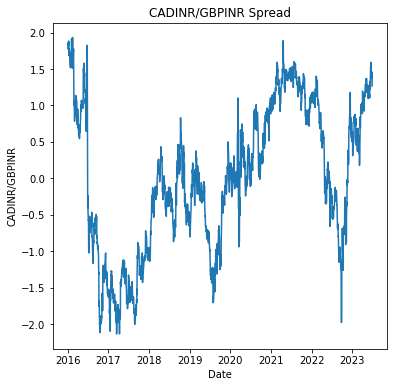

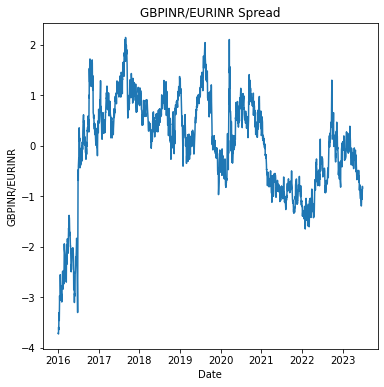

In [18]:
class PairsTest():
    def __init__(self,assets,data):
        self.__assets = assets
        self.__TradingPairs = []
        self.__data = data
        self.__t_statistics = []
        self.__p_values = []
        self.__corr_coeff = []
        self.__spread = pd.DataFrame()
        self.__betas = []
    
    def GetTradingPairs(self):
        return self.__TradingPairs
    
    def Get_t_stats(self):
        return self.__t_statistics
    
    def Get_p_values(self):
        return self.__p_values
    
    def Get_corr_coeff(self):
        return self.__corr_coeff
    
    def Get_Spreads(self):
        return self.__spread
    
    def GetBetas(self):
        return self.__betas
    
    def Find_Normalised_Spread(self):
        for i in range(len(self.__TradingPairs)):
            X_name = self.__TradingPairs[i][:6]+'=X'
            Y_name = self.__TradingPairs[i][7:]+'=X'
            X = self.__data[X_name]
            Y = self.__data[Y_name]
            beta = stat.OLS(X,Y).fit().params[0]
            self.__betas.append(beta)
            spread = Y - beta*X
            mean = spread.mean()
            std = spread.std()
            z_score = (spread-mean)/std
            self.__spread[self.__TradingPairs[i]] = z_score
        #print(self.__spread)
    
    def FindCorrelatedPairs(self):
        self.__corr_coeff = self.__data.corr(method='pearson')
        for i in range(len(self.__corr_coeff.columns)):
            for j in range(len(self.__corr_coeff.columns)):
                if j < i:
                    PCC = self.__corr_coeff.iloc[i,j]
                    if PCC > 0.8:
                        X = self.__corr_coeff.columns[i]
                        Y = self.__corr_coeff.columns[j]
                        Pair = X[:6]+'/'+Y[:6]
                        self.__TradingPairs.append(Pair)

    def Engle_Granger(self):
        t_statistics = np.zeros((len(tickers),len(tickers)))
        p_values = np.zeros((len(tickers),len(tickers)))
        currency_pairs = []
        high_t_stats = []
        engle_granger = pd.DataFrame()
        for i in range(len(self.__data.columns)):
            for j in range(len(self.__data.columns)):
                if j < i:
                    X = self.__data.iloc[:,i]
                    Y = self.__data.iloc[:,j]
                    t_statistics[i][j]=coint(X,Y)[0]
                    p_values[i][j]=round(coint(X,Y)[1],3)
                    if coint(X,Y)[0] < -2.86 and coint(X,Y)[1] < 0.05:
                        first = self.__data.columns[i]
                        second = self.__data.columns[j]
                        pair = first[:6] + '/' + second[:6]
                        currency_pairs.append(pair)
                        high_t_stats.append(coint(X,Y)[0])
                else:
                    p_values[i][j]=1
        self.__TradingPairs = currency_pairs
        self.__t_statistics = t_statistics
        self.__p_values = p_values
    
    def HurstExponent(self):
        spreads = pd.DataFrame()
        pairs=[]
        HCs = {}
        for i in range(0,len(self.__spread.columns)):
            HC = compute_Hc(self.__spread[self.__spread.columns[i]])[0]
            if 0 < HC < 0.5:
                spreads[self.__spread.columns[i]] = self.__spread[self.__spread.columns[i]]
                HCs[self.__spread.columns[i]] = HC
        sorted_HCs = sorted(HCs.items(),key=lambda x:x[1])
        HCs_top_three = sorted_HCs[:3]
        for pair in HCs_top_three:
            pairs.append(pair[0])
        self.__TradingPairs = pairs
        self.__spread = spreads[self.__TradingPairs]
    
    def Plots(self):
        plt.figure(figsize=(16,16))
        mask = np.triu(np.ones_like(self.Get_corr_coeff(),dtype=np.bool))
        heatmap = sns.heatmap(self.Get_corr_coeff(),mask=mask,annot=True,vmin=-1,vmax=1)
        heatmap.set_title('Correlation Heatmap')
        
        plt.figure(figsize=(16,16))
        mask = np.triu(np.ones_like(self.Get_t_stats(),dtype=np.bool))
        heatmap = sns.heatmap(self.Get_t_stats(),mask=mask,annot=True,xticklabels=self.__assets,
                              yticklabels=self.__assets)
        heatmap.set_title('T-statistic Heatmap')
        
        plt.figure(figsize=(18,18))
        mask = np.triu(np.ones_like(self.Get_p_values(),dtype=np.bool))
        heatmap = sns.heatmap(self.Get_p_values(),mask=mask,annot=True,xticklabels=self.__assets,
                              yticklabels=self.__assets)
        heatmap.set_title('P-Values Heatmap')
    
    def Plot_Z_Score(self,pairs):
        data = self.__spread
        data = data.reset_index()
        data['Date']=pd.to_datetime(data['Date'])
        for i in range(len(pairs)):
            plt.figure(figsize=(6,6))
            plt.title(pairs[i]+' Spread')
            sns.lineplot(x=data['Date'],y=data[pairs[i]])
    
    def PlotPrices(self):
        data = self.__data.reset_index()
        for pair in self.__TradingPairs:
            X_name = pair[:6]+'=X'
            Y_name = pair[7:]+'=X'
            X_price = data[X_name]
            Y_price = data[Y_name]
            plt.figure()
            sns.lineplot(x=data['Date'],y=X_price)
            plt.figure()
            sns.lineplot(x=data['Date'],y=Y_price)
            
            
find_pairs = PairsTest(tickers,data)
find_pairs.FindCorrelatedPairs()
find_pairs.Engle_Granger()
#find_pairs.Plots()
find_pairs.Find_Normalised_Spread()
find_pairs.HurstExponent()
trading_pairs = find_pairs.GetTradingPairs()
spreads = find_pairs.Get_Spreads()
betas = find_pairs.GetBetas()
#print(trading_pairs)
find_pairs.Plot_Z_Score(trading_pairs)
#find_pairs.PlotPrices()



## Strategy

The strategy we employ will be based off the spread. Note that the mean $\mu$ of the spread will always be 0. This is because of the way we have estimated $\beta$ using linear regression. The standard deviation $s$ will be 1 as well. Let X be the predictor FX pair and let Y be the response FX pair.

Signals to open positions:

- If the spread crosses the $\mu - s$ line from below, you long X and short Y in ratio 1:$\beta$. (1)
- If the spread crosses the $\mu + s$ line from above, you short X and long Y in ratio 1:$\beta$. (2)

Stop Loss Condition:

- (1): Following 1, if the spread crosses the $\mu - 2s$ line from above, exit any positions entered.
- (2): Following 2, if the spread crosses the $\mu + 2s$ line from below, exit any positions entered.

Take Profit Condition:

- (1): Following 1, if stop loss condition hasn't been met and spread crosses the $\mu$ line from below, exit any positions entered.
- (2): Following 2, if stop loss condition hasn't been met and spread crosses the $\mu$ line from above, exit any positions entered.

The graphs below denote the entry and exit of positions on the spreads of the 3 cointegrated pairs over a 7-year period.

Index(['USDINR=X', 'EURINR=X', 'AUDINR=X', 'GBPINR=X', 'CADINR=X', 'JPYINR=X',
       'CHFINR=X', 'HKDINR=X', 'SGDINR=X'],
      dtype='object')


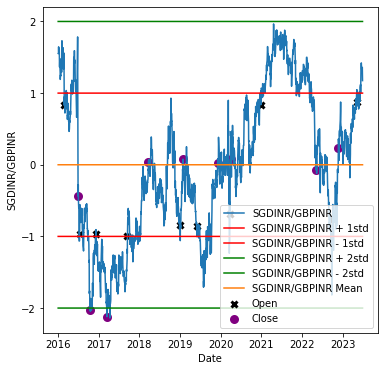

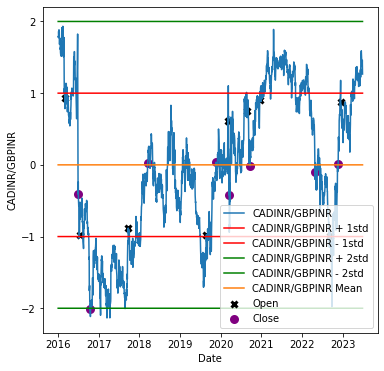

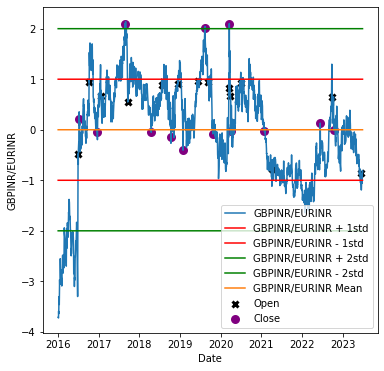

In [19]:
class Backtest():
    def __init__(self,trading_pairs,data,betas):
        self.__trading_pairs = trading_pairs
        self.__data = data.reset_index()
        self.__betas = betas
        self.__currency_prices = pd.DataFrame()
        self.__position = 'NONE'
        self.__open = 'NONE'
        self.__open_position = False
        self.__current_capital = 100
        self.__capital = [self.__current_capital]
        self.__num_trades = 0
        self.__wins = 0
        self.__losses = 0
        self.__win_profits = []
        self.__loss_profits = []
        self.__max_drawdown = 0
    
    def GetTradingPairs(self):
        return self.__trading_pairs
    
    def GetData(self):
        return self.__data
    
    def GetCurrencyPrices(self):
        return self.__currency_prices
    
    def GetCurrentCapital(self):
        return self.__current_capital
    
    def GetCapital(self):
        return self.__capital
    
    def GetNumTrades(self):
        return self.__num_trades,self.__wins,self.__losses
    
    def GetAvgWin(self):
        Avg = np.average(self.__win_profits)
        return Avg
    
    def GetAvgLoss(self):
        Avg = np.average(self.__loss_profits)
        return Avg
    
    def SetCurrencyPrices(self,data):
        Currencies = []
        print(data.columns)
        for i in range(len(self.__trading_pairs)):
            X = self.__trading_pairs[i][:6]
            Y = self.__trading_pairs[i][7:]
            if X not in Currencies:
                Currencies.append(X)
                self.__currency_prices[X] = data[X+'=X']
            if Y not in Currencies:
                Currencies.append(Y)
                self.__currency_prices[Y] = data[Y+'=X']
    
    def StdBands(self):
        columns = ['Date']
        for i in range(len(self.__trading_pairs)):
            std = self.__data[self.__trading_pairs[i]].std()
            mean = self.__data[self.__trading_pairs[i]].mean()
            plus_one_std = [mean+std for i in range(len(self.__data))]
            minus_one_std = [mean-std for i in range(len(self.__data))]
            minus_two_std = [mean-2*std for i in range(len(self.__data))]
            plus_two_std = [mean+2*std for i in range(len(self.__data))]
            mean_col = [mean for i in range(len(self.__data))]
            self.__data[self.__trading_pairs[i]+' + 1std'] = plus_one_std
            self.__data[self.__trading_pairs[i]+' - 1std'] = minus_one_std
            self.__data[self.__trading_pairs[i]+' + 2std'] = plus_two_std
            self.__data[self.__trading_pairs[i]+' - 2std'] = minus_two_std
            self.__data[self.__trading_pairs[i]+' Mean'] = mean_col
            columns.extend([self.__trading_pairs[i],self.__trading_pairs[i]+' + 1std',
                          self.__trading_pairs[i]+' - 1std',
                          self.__trading_pairs[i]+' + 2std',
                          self.__trading_pairs[i]+' - 2std',  self.__trading_pairs[i]+' Mean'])
        self.__data = self.__data[columns]
    
    def FindTradeSignals(self):
        for i in range(len(self.__trading_pairs)):
            self.__position='NONE'
            self.__open_position=False
            spread = self.__data[self.__trading_pairs[i]]
            std = spread.std()
            mean = spread.mean()
            long_pos = ['NONE']
            short_pos = ['NONE']
            for day in range(1,len(spread)):
                self.DetermineCross(spread,day,std,mean)
                if self.__position=='LONG':
                    long_pos.append('LONG')
                    short_pos.append('NONE')
                elif self.__position=='SHORT':
                    long_pos.append('NONE')
                    short_pos.append('SHORT')
                else:
                    long_pos.append('NONE')
                    short_pos.append('NONE')
            self.__data[self.__trading_pairs[i]+' Long Pos'] = long_pos
            self.__data[self.__trading_pairs[i]+' Short Pos'] = short_pos
    
    def DetermineCross(self,spread,day,std,mean):
        if self.__position == 'NONE' and self.__open_position==False:
            if spread[day-1]<=mean-std and spread[day]>mean-std:
                self.__position = 'LONG'
                self.__open_position = True
            elif spread[day-1]>mean+std and spread[day]<mean+std:
                self.__position = 'SHORT'
                self.__open_position = True
        elif self.__position=='LONG' and self.__open_position==True:
            if spread[day-1]<=mean and spread[day]>mean:
                self.__position='NONE'
                self.__open_position=False
            elif spread[day-1]>=mean-2*std and spread[day]<mean-2*std:
                self.__position='NONE'
                self.__open_position=False
        elif self.__position=='SHORT' and self.__open_position==True:
            if spread[day-1]>=mean and spread[day]<mean:
                self.__position='NONE'
                self.__open_position=False
            elif spread[day-1]<=mean+2*std and spread[day]>mean+2*std:
                self.__position='NONE'
                self.__open_position=False
    
    def FindProfit(self):
        pair_pos = {}
        for pair in self.__trading_pairs:
            pair_pos[pair] = Position('NONE',pair,0)
        for day in range(1,len(self.__data)):
            for pair in self.__trading_pairs:
                long_pos_yest = self.__data[pair+' Long Pos'][day-1]
                long_pos_today = self.__data[pair+' Long Pos'][day]
                short_pos_yest = self.__data[pair+' Short Pos'][day-1]
                short_pos_today = self.__data[pair+' Short Pos'][day]
                X_name = pair[:6]
                Y_name = pair[7:]
                X_price = self.__currency_prices[X_name][day]
                Y_price = self.__currency_prices[Y_name][day]
                index = self.__trading_pairs.index(pair)
                if long_pos_yest=='NONE' and long_pos_today=='LONG':
                    pair_pos[pair] = Position('LONG',pair,self.__betas[index])
                    pair_pos[pair].SetCosts(X_price,Y_price)
                        
                elif long_pos_yest=='LONG' and long_pos_today=='NONE':
                    profit = pair_pos[pair].ExitPosition(X_price,Y_price)
                    self.__current_capital += profit
                    if profit>0:
                        self.__wins += 1
                        self.__win_profits.append(profit)
                    else:
                        self.__losses += 1
                        self.__loss_profits.append(profit)
                    self.__num_trades += 1
                
                elif short_pos_yest=='NONE' and short_pos_today=='SHORT':
                    pair_pos[pair] = Position('SHORT',pair,self.__betas[index])
                    pair_pos[pair].SetCosts(X_price,Y_price)
                        
                elif short_pos_yest=='SHORT' and short_pos_today=='NONE':
                    profit = pair_pos[pair].ExitPosition(X_price,Y_price)
                    self.__current_capital += profit
                    if profit>0:
                        self.__wins += 1
                    else:
                        self.__losses += 1
                    self.__num_trades += 1
                    
            self.__capital.append(self.__current_capital)
        self.__capital = pd.Series(self.__capital)
    
    def MaxDrawdown(self):
        capital = self.__capital.tolist()
        for i in range(1,len(capital)):
            if capital[i] - capital[i-1] < -1*self.__max_drawdown:
                self.__max_drawdown = capital[i-1] - capital[i]
        return self.__max_drawdown
    
    def ToExcel(self):
        with pd.ExcelWriter('Pairs_Trading_Result.xlsx') as writer:
            self.__data.to_excel(writer,sheet_name='Spread Data')
            self.__currency_prices.to_excel(writer,sheet_name='Currency Data')
    
    def PlotEquityCurve(self):
        plt.figure(figsize=(8,8))
        sns.lineplot(x=self.__data['Date'],y=self.__capital)
        plt.ylabel('Equity in INR')
                    
    def PlotTrades(self):
        data = self.__data
        for i in range(len(self.__trading_pairs)):
            plt.figure(figsize=(6,6))
            sns.lineplot(x=data['Date'],y=data[self.__trading_pairs[i]])
            sns.lineplot(x=data['Date'],y=data[self.__trading_pairs[i]+' + 1std'],color='red')
            sns.lineplot(x=data['Date'],y=data[self.__trading_pairs[i]+' - 1std'],color='red')
            sns.lineplot(x=data['Date'],y=data[self.__trading_pairs[i]+' + 2std'],color='green')
            sns.lineplot(x=data['Date'],y=data[self.__trading_pairs[i]+' - 2std'],color='green')
            sns.lineplot(x=data['Date'],y=data[self.__trading_pairs[i]+' Mean'])
            for j in range(1,len(data[self.__trading_pairs[i]])):
                long_pos = data[self.__trading_pairs[i]+' Long Pos']
                short_pos = data[self.__trading_pairs[i]+' Short Pos']
                if (long_pos[j-1]=='NONE' and long_pos[j]=='LONG'):
                    plt.scatter(data['Date'][j],data[self.__trading_pairs[i]][j],marker='x',color='black',linewidths=3)
                elif (short_pos[j-1]=='NONE' and short_pos[j]=='SHORT'):
                    plt.scatter(data['Date'][j],data[self.__trading_pairs[i]][j],marker='x',color='black',linewidths=3)
                elif (long_pos[j-1]=='LONG' and long_pos[j]=='NONE'):
                    plt.scatter(data['Date'][j],data[self.__trading_pairs[i]][j],marker='o',color='purple',linewidths=3)
                elif (short_pos[j-1]=='SHORT' and short_pos[j]=='NONE'):
                    plt.scatter(data['Date'][j],data[self.__trading_pairs[i]][j],marker='o',color='purple',linewidths=3)
        
            plt.legend(labels=[self.__trading_pairs[i],self.__trading_pairs[i]+' + 1std',
                               self.__trading_pairs[i]+' - 1std',self.__trading_pairs[i]+' + 2std',
                               self.__trading_pairs[i]+' - 2std',self.__trading_pairs[i]+' Mean',
                               'Open','Close'],loc='lower right')

class Position():
    def __init__(self,pos_type,pair,beta):
        self.__pos_type = pos_type
        self.__pair = pair
        self.__beta = beta
        self.__X_costs = 0
        self.__X_profits = 0
        self.__Y_costs = 0
        self.__Y_profits = 0
    
    def GetPair(self):
        return self.__pair

    def SetCosts(self,X_price,Y_price):
        if self.__pos_type == 'LONG':
            self.__X_costs += X_price
            self.__Y_costs -= self.__beta*Y_price
        else:
            self.__X_costs -= X_price
            self.__Y_costs += self.__beta*Y_price
    
    def ExitPosition(self,X_price,Y_price):
        if self.__pos_type == 'LONG':
            self.__X_profits -= X_price
            self.__Y_profits += self.__beta*Y_price
        else:
            self.__X_costs += X_price
            self.__Y_costs -= self.__beta*Y_price
        X_profit = self.__X_costs + self.__X_profits
        Y_profit = self.__Y_costs + self.__Y_profits
        return X_profit + Y_profit
            

backtest = Backtest(trading_pairs,spreads,betas)
backtest.SetCurrencyPrices(data)
backtest.StdBands()
backtest.FindTradeSignals()
backtest.PlotTrades()
backtest.FindProfit()
num_trades,num_wins,num_losses = backtest.GetNumTrades()
    

## Hit Ratio and Equity Curve

The first metric we will to evaluate this strategy is the Hit Ratio, this is the ratio of winning trades to losing trades. A winning trade is one that made a profit, a losing trade is one that made a loss. As shown below, our hit ratio is 0.8

Below is the equity curve. This shows how my capital has fared over time. As shown, the strategy increased my capital by roughly 70% over a 7-year period. 

+ve Trades:  24
-ve Trades:  6
Hit Ratio:  0.8


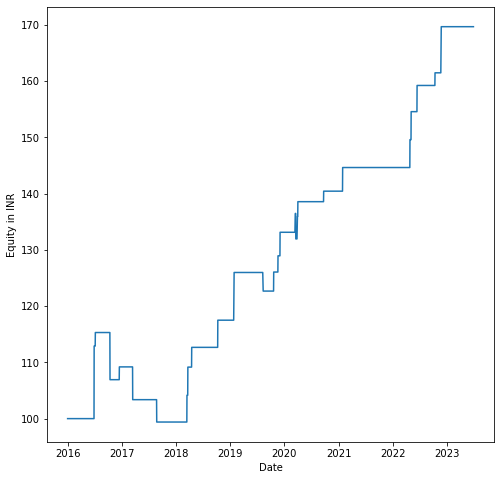

In [15]:
backtest.PlotEquityCurve()
print('+ve Trades: ', num_wins)
print('-ve Trades: ',num_losses)
print('Hit Ratio: ', num_wins/(num_wins+num_losses))

## Expectancy Ratio and Maximum Drawdown

The expectancy ratio divides the average win by the average loss. For this strategy, the average win was smaller than the average loss. 

The maximum drawdown is the maximum sustained loss from a peak in the equity curve. The maximum drawdown most likely occurred during 2017 since the stop loss was invoked 3 times over this year leading to some 'losing' trades. 

In [7]:
print('Average Win: ',backtest.GetAvgWin())
print('Average loss: ',backtest.GetAvgLoss())
print('Expectancy Ratio: ',backtest.GetAvgWin()/abs(backtest.GetAvgLoss()))

Average Win:  4.074079848508825
Average loss:  -4.7350110313701705
Expectancy Ratio:  0.8604161260697017


In [9]:
print('Max Drawdown: ',backtest.MaxDrawdown())

Max Drawdown:  8.380084088715535


## Conclusion

As shown, the strategy has shown itself to be continuously profitable over a 7-year period and mitigates risk very well. This verifies the belief that pairs trading strategies deliver profits irrespective of market conditions. However, it offers limited profit potential as shown by the lower expectancy ratio. Also, it remains to be seen what the impact of margins and the difference in bid and offer prices have on the profitability of this strategy.